In [1]:
import torch
import os
from tqdm.notebook import tqdm
from setup_cavity import CavityProblem
from pod_rbf import err
from quadnet import QuadNet
from corrected_rom import CorrectedROM
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 18 
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Computer Modern Roman']
matplotlib.rcParams['image.cmap'] = 'RdBu_r'

In [2]:
dims = [3,5,7,9]
sizes = [10,20,30,40,50,100]#,150,200]
ndim = len(dims)
ntrain = len(sizes)
errors = np.full((ndim,ntrain),np.nan)

In [3]:
dimtoind = dict(zip(dims,list(range(ndim))))
sizetoind = dict(zip(sizes,list(range(ntrain))))

In [4]:
infile = open("cavity_sensitivity_log_v5.txt")
lines = infile.readlines()
for line in lines:
    if line.startswith("r="):
        chunks = line.strip().split(",")
        dim = chunks[0].split('=')[-1]
        size = chunks[1].split('=')[-1]
        i = dimtoind[int(dim)]
        j = sizetoind[int(size)]
        errors[i,j] = chunks[3].split('=')[-1]
infile.close()

In [5]:
versions = []
for line in lines:
    bits = line.split()
    for bit in bits:
        bit = bit.strip()
        bit = bit.strip(',')
        if bit.startswith('v_num'):
            versions.append(int(bit.split('=')[-1]))

In [6]:
n_queries = 1

error_corrected = np.zeros((ndim,ntrain))
error_pod = np.zeros((ndim,ntrain))
error_base = np.zeros((ndim,ntrain))
error_nointerp = np.zeros((ndim,ntrain))
pbar = tqdm(total=ndim*ntrain)
for i,reddim in enumerate(dims):
    for j,size in enumerate(sizes):
    
        cavity = CavityProblem('mag(v)',reddim=reddim,train_size=size,test_size=50,device='gpu')

        # POD-RBF error
        coef_test = cavity.rbf(cavity.params_test)
        pred = cavity.pod.expand(coef_test)
        error_pod[i,j] = err(cavity.snapshots_test, pred)[0]

        # POD error
        error_base[i,j] = err(cavity.snapshots_test, cavity.pod.expand(cavity.pod.reduce(cavity.snapshots_test)))[0]

        id_ = versions[i*ntrain+j]
        corr_net = QuadNet(cavity.modes, cavity.coords)
    
        directory = os.path.join("./",f'lightning_logs/version_{id_}/checkpoints/')
        filename = os.listdir(directory)[0]

        rom = CorrectedROM.load_from_checkpoint(
                checkpoint_path=os.path.join(directory,filename),
                problem = cavity.problem,
               reduction_network = cavity.pod,
               interpolation_network = cavity.rbf,
               correction_network = corr_net)
        #rom.cpu()
        rom.eval()
        # Corrected error NO INTERPOLATION
        pred = rom._forward_no_interp(cavity.params_test,cavity.snapshots_test)
        error_nointerp[i,j] = err(cavity.snapshots_test, pred)[0]
        
        #Corrected error
        pred = rom(cavity.params_test)
        error_corrected[i,j] = err(cavity.snapshots_test,pred)[0]
        pbar.update(1)

#error_corrected /= n_queries
#error_pod /= n_queries
#error_base /= n_queries
#error_nointerp /= n_queries


  0%|          | 0/24 [00:00<?, ?it/s]

In [19]:
error_pod

array([[0.55926281, 0.47295651, 0.324543  , 0.26389927, 0.16206084,
        0.1527935 ],
       [0.55375683, 0.46549183, 0.28600499, 0.22631088, 0.11121137,
        0.09277417],
       [0.55540878, 0.46697989, 0.28136057, 0.21877418, 0.09928361,
        0.06765699],
       [0.5548681 , 0.46613249, 0.28134555, 0.21661612, 0.09180249,
        0.06461985]])

In [32]:
cc = corr_net.C(cavity.params_test)[0][0].tensor.cpu().squeeze()
op = torch.zeros((9,9))
for i in range(9):
    for j in range(i,9):
        op[i,j] = cc[i*(9-i)+j]
for i in range(9):
    for j in range(i+1,9):
        op[j,i] = op[i,j]
print(torch.linalg.cond(op))

tensor(41.0438, grad_fn=<SqueezeBackward1>)


In [31]:
torch.allclose(op,op.T)

True

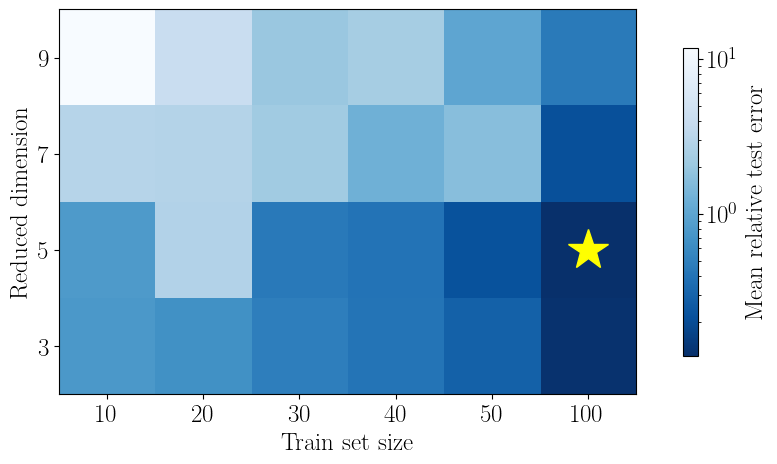

In [17]:
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(error_corrected,cmap='Blues_r',norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(error_corrected.argmin(),error_corrected.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)#,markeredgewidth=5)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#for i in range(4):
#    for j in range(8):
#        ax.text(j,i,f'{errors[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Mean relative test error')

In [18]:
time = 0
for line in lines:
    bits = line.split()
    for bit in bits:
        bit = bit.strip()
        bit = bit.strip(',')
        if bit.startswith('train_time'):
            time += float(bit.split('=')[-1])

In [19]:
time/3600

18.2723975366354

In [17]:
loss = np.empty(ndim*ntrain)
i = 0
for line in lines:
    bits = line.split()
    for bit in bits:
        bit = bit.strip()
        bit = bit.strip(',')
        if bit.startswith('loss_corr'):
            loss[i] = float(bit.split('=')[-1])
            i += 1
loss = loss.reshape((ndim,ntrain))

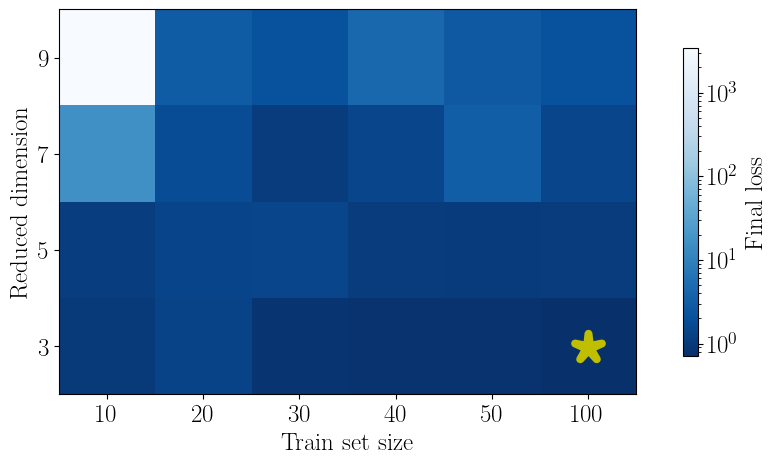

In [24]:
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(loss,cmap='Blues_r',norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(loss.argmin(),loss.shape)
ax.plot(best[1],best[0],'y',marker=r'$\star$',ms=20,markeredgewidth=5)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#for i in range(4):
#    for j in range(8):
#        ax.text(j,i,f'{loss[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Final loss')

In [9]:
from utils import plot

In [15]:
cavity.params_train.min()

LabelTensor(0., device='cuda:0')

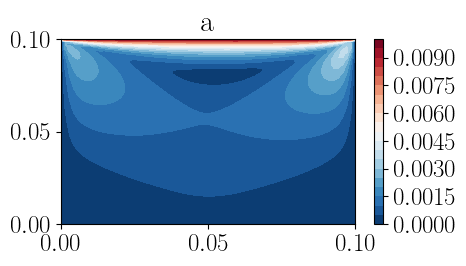

In [14]:
plot(cavity.data.triang,[cavity.snapshots_train[cavity.params_train.argmin()].cpu().detach().numpy().reshape(-1)],['a'])

## POD RBF

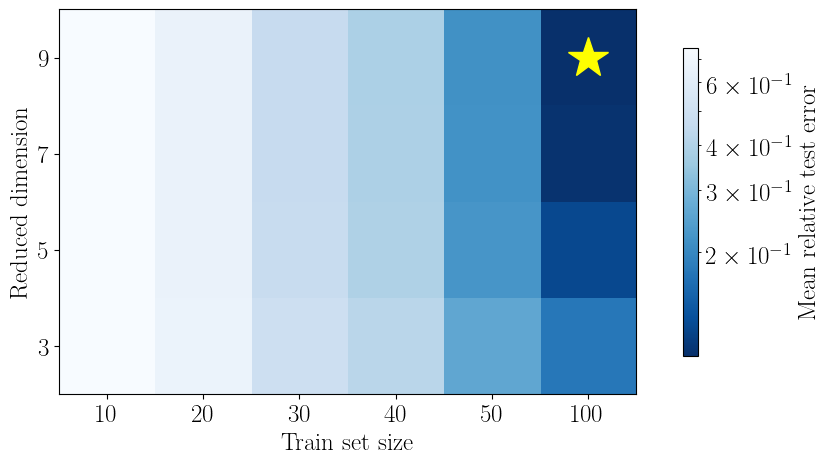

In [25]:
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(error_pod,cmap='Blues_r',norm=matplotlib.colors.LogNorm())
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(error_pod.argmin(),error_pod.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)#,markeredgewidth=5)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

#for i in range(4):
#    for j in range(8):
#        ax.text(j,i,f'{error_pod[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Mean relative test error')

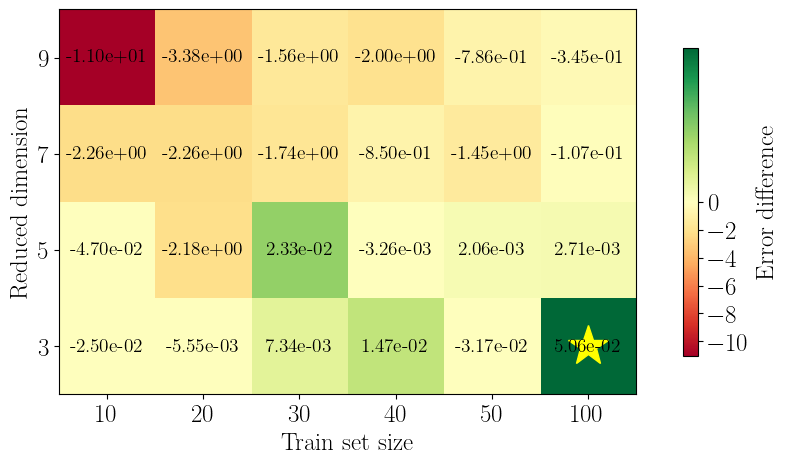

In [27]:
difference = (error_pod - error_corrected)#/error_pod
fig,ax = plt.subplots(figsize=(12,5))
#heat = ax.imshow((difference>0),cmap=matplotlib.colors.ListedColormap(['#FF7373','#73FF73']))#,norm=matplotlib.colors.TwoSlopeNorm(0,-0.06,0.06))
heat = ax.imshow((difference),cmap='RdYlGn',norm=matplotlib.colors.TwoSlopeNorm(0,difference.min(),difference.max()))
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')


best = np.unravel_index(difference.argmax(),difference.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)#,markeredgewidth=5)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

for i in range(ndim):
    for j in range(ntrain):
        ax.text(j,i,f'{difference[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Error difference')#,extend='min')


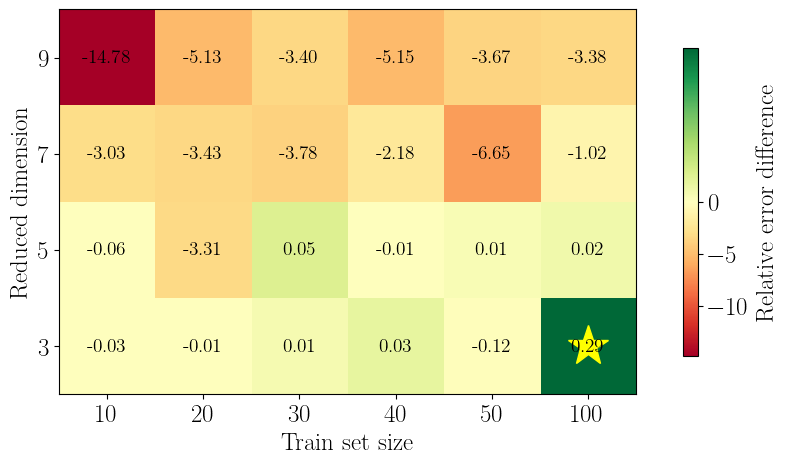

In [28]:
difference = (error_pod - error_corrected)/error_pod #* 100
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow(difference,cmap='RdYlGn',norm=matplotlib.colors.TwoSlopeNorm(0,difference.min(),difference.max()))
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(difference.argmax(),difference.shape)
ax.plot(best[1],best[0],'#FFFF00',marker=r'*',ms=30)#,markeredgewidth=5)
#square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
#ax.add_patch(square)

for i in range(ndim):
   for j in range(ntrain):
       ax.text(j,i,f'{difference[i,j]:.2f}',c='k',ha='center',va='center',fontsize=14)

fig.colorbar(heat,shrink=0.8,label='Relative error difference')#,extend='min',ticks=[-0.05,0,0.2,0.4,0.6,0.8,1])

In [35]:
error_corrected

array([[ 0.77530849,  0.67031646,  0.48292086,  0.40766668,  0.29076493,
         0.12649013],
       [ 0.79435277,  2.84423518,  0.44021854,  0.39851189,  0.22210196,
         0.12114273],
       [ 3.01150131,  2.92018366,  2.19922876,  1.23999512,  1.66256893,
         0.2121044 ],
       [11.79153442,  4.03957462,  2.02438068,  2.39355516,  1.0007714 ,
         0.44751227]])

In [29]:
cm = plt.get_cmap('RdBu_r')
cols = cm(np.linspace(0.1,0.9,4))

In [38]:
size_arr

array([[ 10,  20,  30,  40,  50, 100],
       [ 10,  20,  30,  40,  50, 100],
       [ 10,  20,  30,  40,  50, 100],
       [ 10,  20,  30,  40,  50, 100]])

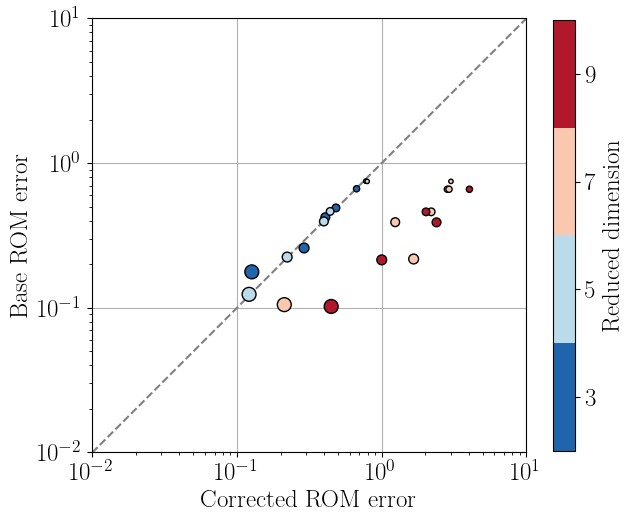

In [31]:
def custom_cmap(x):
    return np.where(x,'green','red').ravel()

colors = custom_cmap(error_pod>error_corrected)

dim_arr = np.array(dims).repeat(ntrain).reshape((ndim,ntrain))
size_arr = np.array(sizes)[None,:].repeat(ndim,axis=0)

fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(1e-2,10)
ax.set_ylim(1e-2,10)
ax.set_aspect('equal')
ax.grid()
scat = ax.scatter(error_corrected,error_pod,marker='o',c=dim_arr,s=size_arr,zorder=10,cmap=matplotlib.colors.ListedColormap(cols),edgecolors='k')
ax.loglog(np.array([0,10]).T,np.array([0,10]).T,'--',c='grey')
ax.set_xlabel('Corrected ROM error')
ax.set_ylabel('Base ROM error')
cbar = plt.colorbar(scat,shrink=0.8,label='Reduced dimension',ticks=dims,boundaries=np.arange(2,11,2))

## Compare with base POD (no RBF)

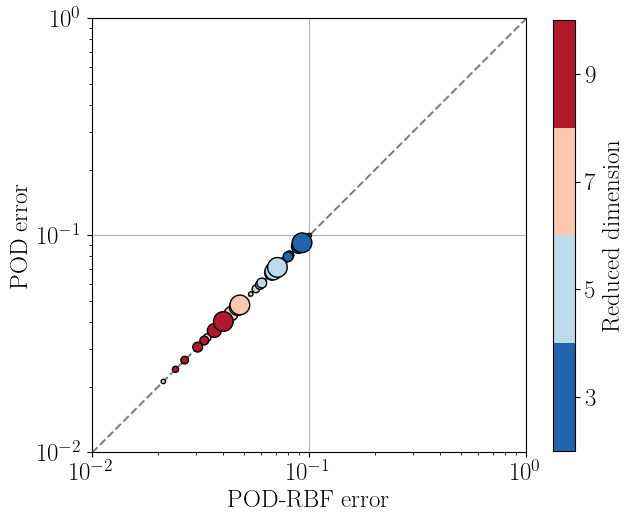

In [33]:
def custom_cmap(x):
    return np.where(x,'green','red').ravel()

colors = custom_cmap(error_base>error_pod)

dim_arr = np.array(dims).repeat(8).reshape((4,8))
size_arr = np.array(sizes)[None,:].repeat(4,axis=0)

fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(1e-2,1)
ax.set_ylim(1e-2,1)
ax.set_aspect('equal')
ax.grid(zorder=-10)
ax.loglog(np.array([0,1]).T,np.array([0,1]).T,'--',c='grey',zorder=-1)
scat = ax.scatter(error_pod,error_base,marker='o',c=dim_arr,s=size_arr,zorder=10,edgecolors='k',cmap=matplotlib.colors.ListedColormap(cols))
ax.set_xlabel('POD-RBF error')
ax.set_ylabel('POD error')
plt.colorbar(scat,shrink=0.8,label='Reduced dimension',ticks=dims,boundaries=np.arange(2,11,2))

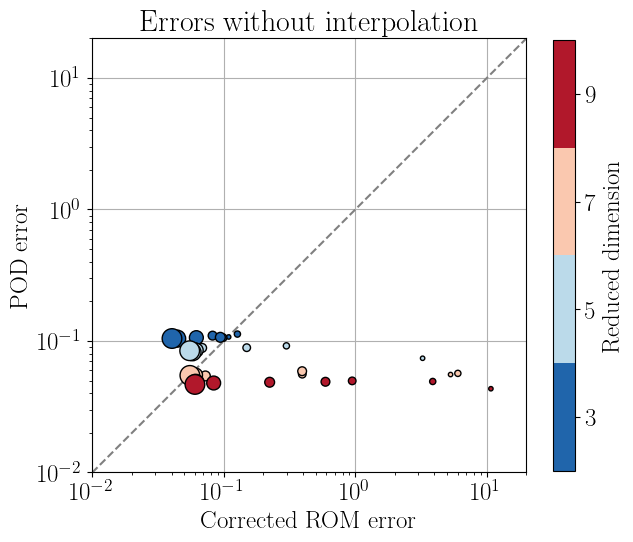

In [22]:
def custom_cmap(x):
    return np.where(x,'green','red').ravel()

colors = custom_cmap(error_base>error_nointerp)

fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(1e-2,20)
ax.set_ylim(1e-2,20)
ax.set_aspect('equal')
ax.grid()
scat = ax.scatter(error_nointerp,error_base,marker='o',c=dim_arr,s=size_arr,zorder=10,edgecolors='k',cmap=matplotlib.colors.ListedColormap(cols))
ax.loglog(np.array([0,20]).T,np.array([0,20]).T,'--',c='grey')
ax.set_title('Errors without interpolation')
ax.set_xlabel('Corrected ROM error')
ax.set_ylabel('POD error')
plt.colorbar(scat,shrink=0.8,label='Reduced dimension',ticks=dims,boundaries=np.arange(2,11,2))


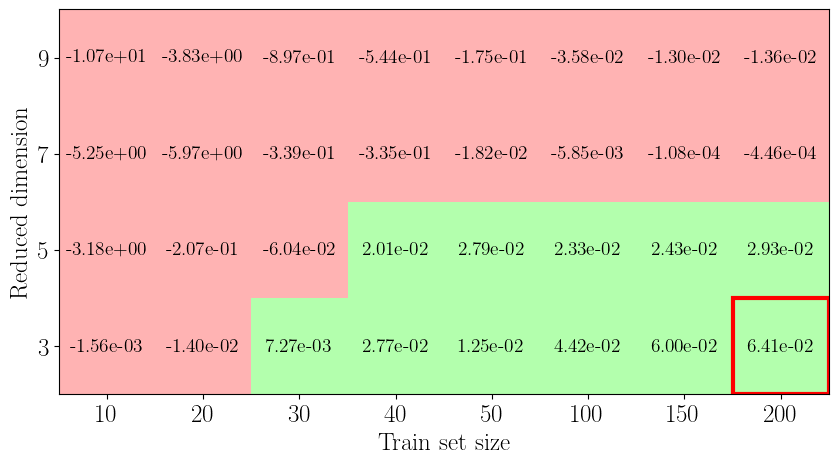

In [23]:
difference = (error_base - error_nointerp)
fig,ax = plt.subplots(figsize=(12,5))
heat = ax.imshow((difference>0),cmap=matplotlib.colors.ListedColormap(['#FFB3B3','#B3FFAD']))#,norm=matplotlib.colors.TwoSlopeNorm(0,-0.06,0.06))
ax.invert_yaxis()
ax.set_xticks(range(ntrain),sizes)
ax.set_yticks(range(ndim),dims)
ax.set_xlabel('Train set size')
ax.set_ylabel('Reduced dimension')

best = np.unravel_index(difference.argmax(),errors.shape)
#ax.plot(best[1],best[0],'y',marker=r'$\star$',ms=20,markeredgewidth=5)
square = matplotlib.patches.Rectangle((best[1]-0.5,best[0]-0.5),1,1,fill=False,edgecolor='r',lw=3)
ax.add_patch(square)

for i in range(4):
    for j in range(8):
        ax.text(j,i,f'{difference[i,j]:.2e}',c='k',ha='center',va='center',fontsize=14)

#fig.colorbar(heat,shrink=0.8,label='Error difference',extend='min')

## Tests on reproducibility
Turns out that both the modes and rbf for different instances of the problem are not equal. The train and test data seems to be the same, which is expected as the train-test split has a seed. This causes issues in experiments since the results vary noticeably from case to case.

In [112]:
torch.manual_seed(10)

In [73]:
b1 = BackstepProblem('mag(v)',reddim=20,train_size=100)
b2 = BackstepProblem('mag(v)',reddim=20,train_size=100)
b3 = BackstepProblem('mag(v)',reddim=20,train_size=100)

print(torch.allclose(b1.params_train,b2.params_train))
print(torch.allclose(b2.params_train,b3.params_train))
print(torch.allclose(b1.params_train,b3.params_train))

print(torch.allclose(b1.params_test,b2.params_test))
print(torch.allclose(b2.params_test,b3.params_test))
print(torch.allclose(b1.params_test,b3.params_test))

True
True
True
True
True
True


In [74]:
print(torch.allclose(b1.modes,b2.modes))
print(torch.allclose(b2.modes,b3.modes))
print(torch.allclose(b1.modes,b3.modes))

False
False
False


In [75]:
print((b1.modes-b2.modes).mean())
print((b2.modes-b3.modes).mean())
print((b1.modes-b3.modes).mean())

no labels
LabelTensor(0.0001)
no labels
LabelTensor(-0.0003)
no labels
LabelTensor(-0.0001)


In [76]:
print(torch.allclose(b1.rbf._coeffs,b2.rbf._coeffs))
print(torch.allclose(b2.rbf._coeffs,b3.rbf._coeffs))
print(torch.allclose(b1.rbf._coeffs,b3.rbf._coeffs))

False
False
False


In [77]:
print((b1.rbf._coeffs - b2.rbf._coeffs).mean())
print((b2.rbf._coeffs - b3.rbf._coeffs).mean())
print((b1.rbf._coeffs - b3.rbf._coeffs).mean())

tensor(0.0007)
tensor(0.0003)
tensor(0.0010)


In [78]:
print(torch.allclose(b1.rbf(b1.params_test), b2.rbf(b2.params_test)))
print(torch.allclose(b2.rbf(b2.params_test), b3.rbf(b3.params_test)))
print(torch.allclose(b1.rbf(b1.params_test), b3.rbf(b3.params_test)))

False
False
False


In [79]:
print((b1.rbf(b1.params_test) - b2.rbf(b2.params_test)).mean())
print((b2.rbf(b2.params_test) - b3.rbf(b3.params_test)).mean())
print((b1.rbf(b1.params_test) - b3.rbf(b3.params_test)).mean())

no labels
LabelTensor(0.0501)
no labels
LabelTensor(-0.0697)
no labels
LabelTensor(-0.0196)


In [228]:
errors,np.load('sensitivity_analysis/backstep/error_corrected.npy').mean(axis=-1)

(array([[0.27815476, 0.19611286, 0.01054723, 0.01046044, 0.01060426,
         0.00392364, 0.00090173, 0.00121473],
        [0.27790278, 0.19654743, 0.01126086, 0.01385556, 0.01094683,
         0.00410349, 0.00041005, 0.00046865],
        [0.27897593, 0.19800536, 0.01059462, 0.01086973, 0.01118629,
         0.00418355, 0.0007168 , 0.00042887],
        [0.27973393, 0.20118335, 0.01440172, 0.01052035, 0.01040367,
         0.00350565, 0.00066814, 0.00074604]]),
 array([[0.29367309, 0.2035673 , 0.01767486, 0.01751679, 0.01632876,
         0.01498386, 0.01180835, 0.0188445 ],
        [0.29637963, 0.19821653, 0.01362511, 0.01736179, 0.01369086,
         0.01043118, 0.00556822, 0.00748556],
        [0.30689331, 0.20466073, 0.01524994, 0.02079485, 0.06790551,
         0.01649613, 0.00258081, 0.00481783],
        [0.26756918, 0.20935175, 0.0563684 , 0.06597037, 0.05381406,
         0.03939582, 0.02391483, 0.02242672]]))

In [229]:
e_c = np.load('sensitivity_analysis/backstep/error_corrected.npy')

(array([ 7.,  0.,  0.,  0.,  0.,  0., 31., 10.,  1., 51.]),
 array([0.00121395, 0.00351285, 0.00581176, 0.00811066, 0.01040956,
        0.01270846, 0.01500737, 0.01730627, 0.01960517, 0.02190408,
        0.02420298]),
 <BarContainer object of 10 artists>)

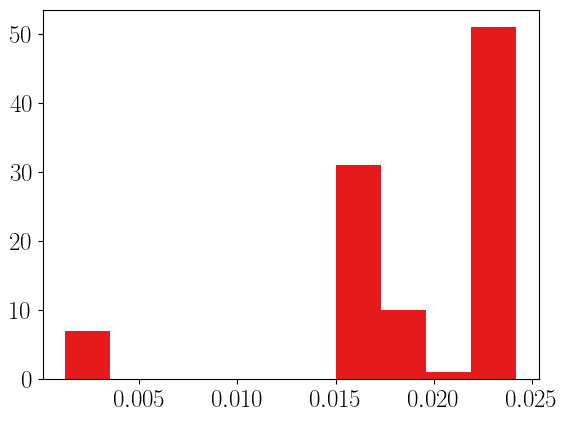

In [230]:
plt.hist(e_c[0,-1,:])

In [69]:
corr_net.modes = backstep.modes
a = rom(backstep.params_test[0])
corr_net.modes = corr_net.modes+torch.randn(corr_net.modes.shape)*1e-4
b = rom(backstep.params_test[0])

(array([  3.,   4.,  32., 315., 935., 311.,  31.,   4.,   2.,   2.]),
 array([-3.06457281e-04, -2.37935776e-04, -1.69414285e-04, -1.00892779e-04,
        -3.23712811e-05,  3.61502171e-05,  1.04671715e-04,  1.73193213e-04,
         2.41714719e-04,  3.10236210e-04,  3.78757715e-04]),
 <BarContainer object of 10 artists>)

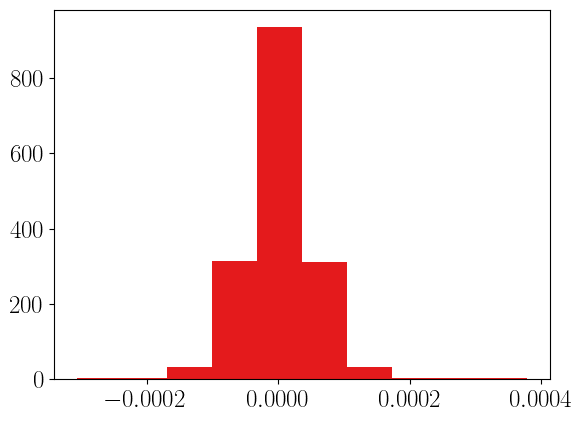

In [72]:
plt.hist((a-b).detach().numpy().ravel())